# Module 4: Trading Simulation

# Imports and Installs

In [45]:
!pip install yfinance

In [46]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
gdown 5.2.0 at /usr/local/lib/python3.11/dist-packages


In [47]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
# import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Imports form ML (Decision Trees)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies
* including newly defined "month-week_of_month"

## 0.1) Read and truncate data (last 25 years from 2000), define variable sets




In [49]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/


Downloading...
From (original): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB
From (redirected): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB&confirm=t&uuid=d99682e8-b183-4bf4-9e4f-f3a6004dbd19
To: /content/stocks_df_combined_2025_06_13.parquet.brotli
100% 130M/130M [00:00<00:00, 174MB/s]


In [50]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2025_06_13.parquet.brotli", )

In [51]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.2+ MB


In [52]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [53]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

In [54]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close_x','Volume']

In [55]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [56]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [57]:
# we define dummy variables on Dividends and Stock Splits events later, but drop the original abs. values
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Close_y','Dividends','Stock Splits'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Close_y',
 'Dividends',
 'Stock Splits',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close_x',
 'Volume']

In [58]:
# let's define on more custom numerical features
# Add a small constant to avoid log(0)
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x+ 1e-6))

In [59]:
# define columns on Dividends or Stock Splits
df_full['div_payout'] = (df_full.Dividends>0).astype(int)
df_full['stock_split'] = (df_full['Stock Splits']>0).astype(int)

In [60]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume','div_payout','stock_split']

In [61]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [62]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [63]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [64]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [65]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [66]:
df_full.Ticker.nunique()

33

In [67]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 206 entries, Open to stock_split
dtypes: datetime64[ns](3), float64(130), int32(64), int64(7), object(2)
memory usage: 256.1+ MB


In [68]:
# tickers, min-max date, count of daily observations
df.groupby(['Ticker'])['Date'].agg(['min','max','count'])

min        max  count
Ticker                                    
AAPL          2000-01-03 2025-06-13   6401
ACN           2001-07-19 2025-06-13   6012
AMZN          2000-01-03 2025-06-13   6401
ASML          2000-01-03 2025-06-13   6401
AVGO          2009-08-06 2025-06-13   3989
BHARTIARTL.NS 2002-07-01 2025-06-13   5698
BRK-B         2000-01-03 2025-06-13   6401
CDI.PA        2000-01-03 2025-06-13   6540
GOOG          2004-08-19 2025-06-13   5239
HDB           2001-07-20 2025-06-13   6011
HINDUNILVR.NS 2000-01-03 2025-06-13   6351
IBN           2000-03-28 2025-06-13   6342
IDEXY         2010-01-20 2025-06-13   3875
INFY          2000-01-03 2025-06-13   6401
ITC.NS        2000-01-03 2025-06-13   6348
JPM           2000-01-03 2025-06-13   6401
LICI.NS       2022-05-17 2025-06-13    761
LLY           2000-01-03 2025-06-13   6401
LT.NS         2002-07-01 2025-06-13   5701
MC.PA         2000-01-03 2025-06-13   6540
META          2012-05-18 2025-06-13   3287
MSFT          2000-01-03 2025-06-13   6401
NVDA          2000-01-03 2025-06-13   6401
NVO           2000-01-03 2025-06-13   6401
OR.PA         2000-01-03 2025-06-13   6540
RELIANCE.NS   2000-01-03 2025-06-13   6348
RMS.PA        2000-01-03 2025-06-13   6540
SAP           2000-01-03 2025-06-13   6401
SBIN.NS       2000-01-03 2025-06-13   6349
SIE.DE        2000-01-03 2025-06-13   6505
TCS.NS        2002-08-12 2025-06-13   5669
TTE           2000-01-03 2025-06-13   6401
V             2008-03-19 2025-06-13   4338

## 0.2) Dummies

In [69]:
# what are the categorical features?
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [70]:
# dummy variables are not generated from Date and numeric variables

# df.loc[:,'Month'] = df['Month'].dt.strftime('%B').astype('string')

df.loc[:,'Month']= pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')

df.loc[:,'Weekday'] = df['Weekday'].astype('string')
# .astype(str)

/tmp/ipython-input-2619569166.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['January' 'January' 'January' ... 'June' 'June' 'June']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:,'Month']= pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')
/tmp/ipython-input-2619569166.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<StringArray>
['0', '1', '2', '3', '4', '0', '1', '2', '3', '4',
 ...
 '0', '1', '2', '3', '4', '0', '1', '2', '3', '4']
Length: 191795, dtype: string' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:,'Weekday'] = df['Weekday'].astype('string')


### 0.2.1) Create a new string column 'month_wom' (month_week_of_month)

In [71]:
# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

/tmp/ipython-input-1081537706.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)


In [72]:
# check values for week-of-month (should be between 1 and 5)
df.wom.value_counts()

wom
2    45083
3    44006
4    43753
1    43557
5    15396
Name: count, dtype: int64

In [73]:
df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

In [74]:
# examples of encoding
df.month_wom.value_counts()[0:2]

month_wom
June_w1        3882
February_w1    3878
Name: count, dtype: int64

In [75]:
# del wom temp variable
del df['wom']

### 0.2.2) Generate all dummies

In [76]:
# what are the categorical features?
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [77]:
CATEGORICAL = ['Month', 'Weekday', 'ticker_type']

In [78]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [79]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Month_April        191795 non-null  int32
 1   Month_August       191795 non-null  int32
 2   Month_December     191795 non-null  int32
 3   Month_February     191795 non-null  int32
 4   Month_January      191795 non-null  int32
 5   Month_July         191795 non-null  int32
 6   Month_June         191795 non-null  int32
 7   Month_March        191795 non-null  int32
 8   Month_May          191795 non-null  int32
 9   Month_November     191795 non-null  int32
 10  Month_October      191795 non-null  int32
 11  Month_September    191795 non-null  int32
 12  Weekday_0          191795 non-null  int32
 13  Weekday_1          191795 non-null  int32
 14  Weekday_2          191795 non-null  int32
 15  Weekday_3          191795 non-null  int32
 16  Weekday_4          191795 non-null  int32


In [80]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US']

In [81]:
len(DUMMIES)

22

In [82]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [83]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 208 entries, growth_1d to ticker_type_US
dtypes: float64(121), int32(84), int64(3)
memory usage: 244.4 MB


### 1.2.3) Get correlations for month_wom (month-week_of_month) with is_futur

In [84]:
DUMMIES_MONTH_WOM = [k for k in DUMMIES if k.startswith('month_wom')]
# check a few records
DUMMIES_MONTH_WOM[0:2]

[]

In [85]:
corr_month_wom_vs_is_positive_growth_30d_future = df_with_dummies[DUMMIES_MONTH_WOM+TO_PREDICT].corr()['is_positive_growth_30d_future']

In [86]:
corr_month_wom_vs_is_positive_growth_30d_future

growth_future_30d                0.696468
is_positive_growth_30d_future    1.000000
Name: is_positive_growth_30d_future, dtype: float64

In [87]:
# create a dataframe for an easy way to sort
corr_month_wom_vs_is_positive_growth_30d_future_df = pd.DataFrame(corr_month_wom_vs_is_positive_growth_30d_future)

In [88]:
# rename column 'is_positive_growth_5d_future' to 'corr'
corr_month_wom_vs_is_positive_growth_30d_future_df.rename(columns={'is_positive_growth_30d_future':'corr'},inplace=True)

In [89]:
corr_month_wom_vs_is_positive_growth_30d_future_df.loc[:, 'abs_corr'] = corr_month_wom_vs_is_positive_growth_30d_future_df['corr'].abs()

In [90]:
corr_month_wom_vs_is_positive_growth_30d_future_df.sort_values(by='abs_corr')

corr  abs_corr
growth_future_30d              0.696468  0.696468
is_positive_growth_30d_future  1.000000  1.000000

In [91]:
# ANSWER Q1 HA3: # TOP CORR NEW DUMMY with is_positive: ANSWER 0.025 (rounded to 3 digits)

### 1.2.4) Temporal split

In [92]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [93]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [94]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.676399
test          0.163758
validation    0.159843
Name: count, dtype: float64

In [95]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

# 1) Modeling

In [96]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 230 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(85), int64(7), object(5), string(1)
memory usage: 275.8+ MB


In [97]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

Open       High      Low    Close_x      Volume  Dividends  \
3490  35.975752  36.358881  34.3283  35.726719  53228400.0        0.0   

      Stock Splits Ticker  Year    Month  ... Weekday_1 Weekday_2  Weekday_3  \
3490           0.0   MSFT  2000  January  ...         0         0          0   

      Weekday_4  Weekday_5  Weekday_6  ticker_type_EU  ticker_type_INDIA  \
3490          0          0          0               0                  0   

      ticker_type_US  split  
3490               1  train  

[1 rows x 230 columns]

In [98]:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

count        max        min
split                                   
test         31408 2025-06-13 2021-08-20
train       129730 2017-10-25 2000-01-03
validation   30657 2021-08-19 2017-10-26

In [99]:
# check for imbalances of growth for train/test/validation
new_df.groupby(by='split')['growth_future_30d'].describe()

count      mean       std       min       25%       50%  \
split                                                                    
test         30418.0  1.019899  0.102172  0.580332  0.955986  1.016057   
train       129730.0  1.023864  0.123190  0.246131  0.960248  1.020585   
validation   30657.0  1.029596  0.099908  0.461847  0.973991  1.030784   

                 75%       max  
split                           
test        1.077950  1.648934  
train       1.083310  5.179689  
validation  1.086687  1.783610

In [100]:
# what do we try to predict
new_df[TO_PREDICT].head(1)

growth_future_30d  is_positive_growth_30d_future
3490           0.845576                              0

In [101]:
# to be used as features
new_df[NUMERICAL+DUMMIES].head(1)

growth_1d  growth_3d  growth_7d  growth_30d  growth_90d  growth_365d  \
3490   0.998394   0.988341   0.991494    1.372333     1.22295     2.063054   

      growth_dax_1d  growth_dax_3d  growth_dax_7d  growth_dax_30d  ...  \
3490       0.970196       0.983855       1.051736        1.134572  ...   

      Weekday_0  Weekday_1  Weekday_2  Weekday_3  Weekday_4  Weekday_5  \
3490          1          0          0          0          0          0   

      Weekday_6  ticker_type_EU  ticker_type_INDIA  ticker_type_US  
3490          0               0                  0               1  

[1 rows x 208 columns]

## 1.1) Manual 'rule of thumb' predictions
* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_30d>1
* (pred2) (growth_30d>1) & (growth_snp500_30d>1)
* (pred3) (DGS10 <= 4) & (DGS5 <= 1)
* (pred4) (DGS10 > 4) & (FEDFUNDS <= 4.795)

In [102]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

In [103]:
# new manual predictions from HA
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

In [104]:
# sample of 10 observations and predictions
new_df[['cci','growth_30d','growth_snp500_30d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_dgs10_5','pred4_manual_dgs10_fedfunds','is_positive_growth_30d_future']].sample(10)

cci  growth_30d  growth_snp500_30d  pred0_manual_cci  \
11071   88.337301    1.029262           1.054354                 0   
910      9.187591    1.187500           1.050805                 0   
4363  -133.931144    0.965113           1.030809                 0   
4064   189.628936    1.104262           1.049400                 0   
794     -7.795224    0.942185           0.937471                 0   
3216  -163.778157    0.877181           0.898010                 0   
635    123.609213    1.074468           1.034330                 0   
4761   -21.877308    0.934485           1.058597                 0   
3173    94.210174    0.948005           0.919334                 0   
6350   128.400735    1.019665           1.055907                 0   

       pred1_manual_prev_g1  pred2_manual_prev_g1_and_snp  \
11071                     1                             1   
910                       1                             1   
4363                      0                             0   
4064                      1                             1   
794                       0                             0   
3216                      0                             0   
635                       1                             1   
4761                      0                             0   
3173                      0                             0   
6350                      1                             1   

       pred3_manual_dgs10_5  pred4_manual_dgs10_fedfunds  \
11071                     0                            0   
910                       0                            1   
4363                      1                            0   
4064                      1                            0   
794                       0                            1   
3216                      0                            0   
635                       1                            0   
4761                      0                            0   
3173                      1                            0   
6350                      0                            0   

       is_positive_growth_30d_future  
11071                              1  
910                                1  
4363                               0  
4064                               1  
794                                0  
3216                               1  
635                                1  
4761                               1  
3173                               1  
6350                               1

In [105]:
# List of current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [106]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [107]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519
Name: count, dtype: float64
-------

In [108]:
# sample of 10 predictions vs. is_correct vs. is_positive_growth_30d_future (what we're trying to predict)
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(10)

pred0_manual_cci  pred1_manual_prev_g1  pred2_manual_prev_g1_and_snp  \
1562                 0                     1                             1   
693                  0                     1                             1   
1476                 0                     0                             0   
4574                 0                     1                             1   
4045                 0                     1                             1   
4439                 0                     0                             0   
1833                 0                     1                             0   
3010                 0                     0                             0   
6983                 0                     0                             0   
4893                 0                     0                             0   

      pred3_manual_dgs10_5  pred4_manual_dgs10_fedfunds  is_correct_pred0  \
1562                     0                            0                 0   
693                      0                            1                 1   
1476                     0                            0                 0   
4574                     0                            0                 0   
4045                     0                            0                 1   
4439                     0                            0                 0   
1833                     0                            0                 0   
3010                     0                            0                 1   
6983                     0                            0                 0   
4893                     0                            0                 1   

      is_correct_pred1  is_correct_pred2  is_correct_pred3  is_correct_pred4  \
1562                 1                 1                 0                 0   
693                  0                 0                 1                 0   
1476                 0                 0                 0                 0   
4574                 1                 1                 0                 0   
4045                 0                 0                 1                 1   
4439                 0                 0                 0                 0   
1833                 1                 0                 0                 0   
3010                 1                 1                 1                 1   
6983                 0                 0                 0                 0   
4893                 1                 1                 1                 1   

      is_positive_growth_30d_future  
1562                              1  
693                               0  
1476                              1  
4574                              1  
4045                              0  
4439                              1  
1833                              1  
3010                              0  
6983                              1  
4893                              0

In [109]:
len(new_df[new_df.split=='test'])

31408

In [110]:
# ANSWER Q2: best is pred3_manual_dgs10_5 with precision = 0.580 (rounded)

In [111]:
# pred4 seems to be empty on Test - let's check why?

# it used to be some stats
new_df[(new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)]

Open        High         Low     Close_x       Volume  Dividends  \
3682   17.010899   17.547278   16.934273   16.972586   81099400.0        0.0   
3683   17.106682   17.394028   16.781023   17.030056   61794000.0        0.0   
3684   17.049210   17.087522   16.244640   16.608612   58323600.0        0.0   
3689   16.397884   16.493666   15.191030   15.440063  119759000.0        0.0   
3690   15.899824   16.072232   15.401757   15.459227   81276600.0        0.0   
...          ...         ...         ...         ...          ...        ...   
1690  115.265769  115.265769  112.248964  112.965836    1009151.0        0.0   
1691  113.503511  115.773583  113.115213  113.981422    1117609.0        0.0   
1692  118.879979  118.879979  113.951538  114.847618     703080.0        0.0   
1693  115.893030  116.191724  113.145047  113.443741    1403644.0        0.0   
1694  125.451253  125.451253  113.981426  115.325546     503141.0        0.0   

      Stock Splits         Ticker  Year    Month  ... pred0_manual_cci  \
3682           0.0           MSFT  2000  October  ...                0   
3683           0.0           MSFT  2000  October  ...                0   
3684           0.0           MSFT  2000  October  ...                0   
3689           0.0           MSFT  2000  October  ...                0   
3690           0.0           MSFT  2000  October  ...                0   
...            ...            ...   ...      ...  ...              ...   
1690           0.0  HINDUNILVR.NS  2002     June  ...                0   
1691           0.0  HINDUNILVR.NS  2002     June  ...                0   
1692           0.0  HINDUNILVR.NS  2002     June  ...                0   
1693           0.0  HINDUNILVR.NS  2002     June  ...                0   
1694           0.0  HINDUNILVR.NS  2002     June  ...                0   

     pred1_manual_prev_g1  pred2_manual_prev_g1_and_snp  pred3_manual_dgs10_5  \
3682                    0                             0                     0   
3683                    0                             0                     0   
3684                    0                             0                     0   
3689                    0                             0                     0   
3690                    0                             0                     0   
...                   ...                           ...                   ...   
1690                    0                             0                     0   
1691                    0                             0                     0   
1692                    0                             0                     0   
1693                    0                             0                     0   
1694                    0                             0                     0   

      pred4_manual_dgs10_fedfunds  is_correct_pred0  is_correct_pred1  \
3682                            0                 0                 0   
3683                            0                 0                 0   
3684                            0                 0                 0   
3689                            0                 0                 0   
3690                            0                 0                 0   
...                           ...               ...               ...   
1690                            1                 1                 1   
1691                            1                 1                 1   
1692                            1                 1                 1   
1693                            1                 1                 1   
1694                            1                 1                 1   

      is_correct_pred2  is_correct_pred3  is_correct_pred4  
3682                 0                 0                 0  
3683                 0                 0                 0  
3684                 0                 0                 0  
3689                 0                 0                 0  
3690   

## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we utilize only Decision Tree Classifier (and not Regressor)

In [112]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [113]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [114]:
# don't use this
# def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
#   # Predict the target variable on the test data
#   y_pred = clf.predict(df_X)

#   # max_depth = clf.tree_.max_depth
#   # Print the maximum depth
#   # print("Maximum depth of the decision tree:", max_depth)

#   # # resulting df
#   # result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

#   return result_df

### 1.2.2) CLF10 (Decision Tree Classifier, max_depth==10): get unique correct predictions vs. pred0_manual...pred4_manual
* Fit(Train) on TRAIN+VALIDATION
* Predict on ALL and Join to the original new_df
* Get Precision on TEST

In [115]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train_valid = train_valid_df[features_list+[to_predict]]
X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train_valid {X_train_valid.shape},  X_test {X_test.shape}, all combined: X_all {X_all.shape}')


length: X_train_valid (160387, 209),  X_test (31408, 209), all combined: X_all (191795, 209)


In [116]:
# Clean from +-inf and NaNs:

X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
# X_test = clean_dataframe_from_inf_and_nan(X_test) # won't use
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [117]:
y_train_valid = X_train_valid[to_predict]
# y_test = X_test[to_predict] # won't use
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_valid[to_predict]
del X_test[to_predict]
del X_all[to_predict]

In [118]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 28.3 s, sys: 176 ms, total: 28.4 s
Wall time: 33.2 s


In [119]:
X_train_valid.shape

(160387, 208)

In [120]:
X_all.shape

(191795, 208)

In [121]:
y_all.shape

(191795,)

In [122]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [123]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [124]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519

In [125]:
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5']

In [126]:
# define a new column that find the cases when only pred5 is correct
new_df['only_pred5_is_correct'] = (new_df.is_correct_pred5==new_df.is_positive_growth_30d_future) & \
                         (new_df.is_positive_growth_30d_future == 1) & \
                         (new_df.is_correct_pred0 == 0) & \
                         (new_df.is_correct_pred1 == 0) & \
                         (new_df.is_correct_pred2 == 0) & \
                         (new_df.is_correct_pred3 == 0) & \
                         (new_df.is_correct_pred4 == 0)

In [127]:
# need it to be integer and not bool
new_df['only_pred5_is_correct'] = new_df['only_pred5_is_correct'].astype(int)

In [128]:
# how many times only pred5 is correct in the TEST set?
new_df[new_df.split=='test']['only_pred5_is_correct'].sum()

np.int64(3571)

In [129]:
# let's look at the record
filter_unique_pred_5 = (new_df.split=='test') & (new_df.only_pred5_is_correct==1)

In [130]:
# sample with only Pred5 correct
new_df[filter_unique_pred_5].sample(10)

Open         High          Low      Close_x      Volume  \
6924    125.582603   125.658612   123.796448   124.271492   1008072.0   
5682     54.209999    54.849998    54.060001    54.400002   5754100.0   
6995   2416.082798  2443.207742  2412.704462  2430.526611   1784812.0   
5141     62.207869    62.882973    61.884989    62.628590    599700.0   
10446    50.053513    50.759910    49.933377    50.639774   2297600.0   
366     604.273969   608.237070   603.877634   605.760132    580132.0   
7143   1452.569996  1471.007420  1450.252909  1458.375244  10081742.0   
6788    303.480297   304.751033   300.938798   304.387970   8105359.0   
4974   1498.616692  1513.249177  1477.740321  1507.767944   1269969.0   
6919    121.877257   122.618324   121.269201   121.421219   1335839.0   

       Dividends  Stock Splits         Ticker  Year     Month  ...  \
6924         0.0           0.0         SIE.DE  2023  November  ...   
5682         0.0           0.0            HDB  2024  February  ...   
6995         0.0           0.0  HINDUNILVR.NS  2023   October  ...   
5141         0.0           0.0            HDB  2021  December  ...   
10446        0.0           0.0            NVO  2022   October  ...   
366          0.0           0.0        LICI.NS  2023  November  ...   
7143         0.0           0.0    RELIANCE.NS  2024      June  ...   
6788         0.0           0.0         ITC.NS  2022  December  ...   
4974         0.0           0.0          LT.NS  2022      July  ...   
6919         0.0           0.0         SIE.DE  2023  November  ...   

      pred3_manual_dgs10_5 pred4_manual_dgs10_fedfunds  is_correct_pred0  \
6924                     0                           0                 0   
5682                     0                           0                 0   
6995                     0                           0                 0   
5141                     0                           0                 0   
10446                    0                           0                 0   
366                      0                           0                 0   
7143                     0                           0                 0   
6788                     0                           0                 0   
4974                     0                           0                 0   
6919                     0                           0                 0   

       is_correct_pred1  is_correct_pred2  is_correct_pred3  is_correct_pred4  \
6924                  0                 0                 0                 0   
5682                  0                 0                 0                 0   
6995                  0                 0                 0                 0   
5141                  0                 0                 0                 0   
10446                 0                 0                 0                 0   
366                   0                 0                 0                 0   
7143                  0                 0                 0                 0   
6788                  0                 0                 0                 0   
4974                  0                 0                 0                 0   
6919                  0                 0                 0                 0   

       pred5_clf_10  is_correct_pred5  only_pred5_is_correct  
6924              1                 1                      1  
5682              1                 1                      1  
6995              1                 1                      1  
5141              1                 1                      1  
10446             1                 1                      1  
366               1                 1                      1  
7143              1                 1                      1  
6788              1                 1                      1  
4974              1                 1                      1  
6919              1                 1                      1  

[10 rows x 243 c

In [131]:
# let's visually check that all predictions are 0, but pred5==1 (sample 10)
new_df[filter_unique_pred_5][PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(10)

pred0_manual_cci  pred1_manual_prev_g1  pred2_manual_prev_g1_and_snp  \
5275                 0                     0                             0   
6170                 0                     0                             0   
5148                 0                     0                             0   
5591                 0                     0                             0   
4936                 0                     0                             0   
3775                 0                     0                             0   
5850                 0                     0                             0   
6544                 0                     0                             0   
5599                 0                     0                             0   
6912                 0                     0                             0   

      pred3_manual_dgs10_5  pred4_manual_dgs10_fedfunds  pred5_clf_10  \
5275                     0                            0             1   
6170                     0                            0             1   
5148                     0                            0             1   
5591                     0                            0             1   
4936                     0                            0             1   
3775                     0                            0             1   
5850                     0                            0             1   
6544                     0                            0             1   
5599                     0                            0             1   
6912                     0                            0             1   

      is_correct_pred0  is_correct_pred1  is_correct_pred2  is_correct_pred3  \
5275                 0                 0                 0                 0   
6170                 0                 0                 0                 0   
5148                 0                 0                 0                 0   
5591                 0                 0                 0                 0   
4936                 0                 0                 0                 0   
3775                 0                 0                 0                 0   
5850                 0                 0                 0                 0   
6544                 0                 0                 0                 0   
5599                 0                 0                 0                 0   
6912                 0                 0                 0                 0   

      is_correct_pred4  is_correct_pred5  is_positive_growth_30d_future  
5275                 0                 1                              1  
6170                 0                 1                              1  
5148                 0                 1                              1  
5591                 0                 1                              1  
4936                 0                 1                              1  
3775                 0                 1                              1  
5850                 0                 1                              1  
6544                 0                 1                              1  
5599                 0                 1                              1  
6912                 0                 1                              1

In [132]:
# ANSWER HA3: 3659 unique correct prediction from clf_10 (on test)

## 1.2.3 [Code Snippet 2] Hyperparams tuning for a Decision Tree Classifier

In [133]:
# TODO HA: Define DUMMIES_SHORT to include only original dummies (and exclude too detailed dummies like month_week_of_month, let's leave only month) --> less features

In [134]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)

test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (129730, 209),  X_validation (30657, 209), X_test (31408, 209), X_train_valid = (160387, 209),  all combined: X_all (191795, 209)


In [135]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)

X_test = clean_dataframe_from_inf_and_nan(X_test)

X_all = clean_dataframe_from_inf_and_nan(X_all)

In [136]:
y_train = X_train[to_predict]
y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

In [137]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text


In [138]:
# (8min runtime) UNCOMMENT TO RUN IT AGAIN
# %%time
# # hyper params tuning for a Decision Tree

# precision_by_depth = {}
# best_precision = 0
# best_depth = 0

# for depth in range(1,21):
#   print(f'Working with a tree of a max depth= {depth}')
#   # fitting the tree on X_train, y_train
#   clf,train_columns = fit_decision_tree(X=X_train_valid,
#                            y=y_train_valid,
#                            max_depth=depth) #applying custom hyperparam
#   # getting the predictions for TEST and accuracy score
#   y_pred_valid = clf.predict(X_valid)
#   precision_valid = precision_score(y_valid, y_pred_valid)
#   y_pred_test = clf.predict(X_test)
#   precision_test = precision_score(y_test, y_pred_test)
#   print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#   # saving to the dict
#   precision_by_depth[depth] = round(precision_test,4)
#   # updating the best precision
#   if precision_test >= best_precision:
#     best_precision = round(precision_test,4)
#     best_depth = depth
#   # plot tree - long
#   # plt.figure(figsize=(20,10))  # Set the size of the figure
#   # plot_tree(clf,
#   #           filled=True,
#   #           feature_names=train_columns,
#   #           class_names=['Negative', 'Positive'],
#   #           max_depth=2)
#   # plt.show()
#   # plot tree - short
#   tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
#   print(tree_rules)
#   print('------------------------------')

# print(f'All precisions by depth: {precision_by_depth}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [139]:
# Results of Hyper parameters tuning for a Decision Tree
# print(precision_by_depth)

In [140]:
# pre-calculated results
precision_by_depth = {1: 0.5466, 2: 0.5511, 3: 0.5511, 4: 0.5511, 5: 0.6278, 6: 0.5691, 7: 0.5945, 8: 0.5891, 9: 0.5912, 10: 0.5888, 11: 0.5916, 12: 0.5855, 13: 0.5822, 14: 0.592, 15: 0.5833, 16: 0.5898, 17: 0.586, 18: 0.5861, 19: 0.5869, 20: 0.5773}




In [141]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 65],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [142]:
%%time
clf_5, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=5)


# predict on a full dataset
y_pred_all = clf_5.predict(X_all)


# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_5'] = y_pred_all

CPU times: user 14.5 s, sys: 172 ms, total: 14.6 s
Wall time: 14.7 s


In [143]:
# MANUAL SECOND BEST, need some complexity
# found earlier in HyperParams Tuning
best_depth = 14
best_precision = precision_by_depth[best_depth]

In [144]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')

Best precision and depth = 14, precision (on test)=0.592


In [145]:
%%time
clf_best, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 34.8 s, sys: 154 ms, total: 34.9 s
Wall time: 35.7 s


In [146]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 4875
Number of leaves: 2438


In [147]:
clf_best

DecisionTreeClassifier(max_depth=14, random_state=42)

In [148]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [149]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred7_clf_second_best'] = y_pred_clf_best

In [150]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred7_clf_second_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984


### 1.2.4) Two ways of visualisation

In [151]:
# train a simple tree
%%time
clf_2,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=2)

CPU times: user 5.8 s, sys: 112 ms, total: 5.91 s
Wall time: 5.92 s


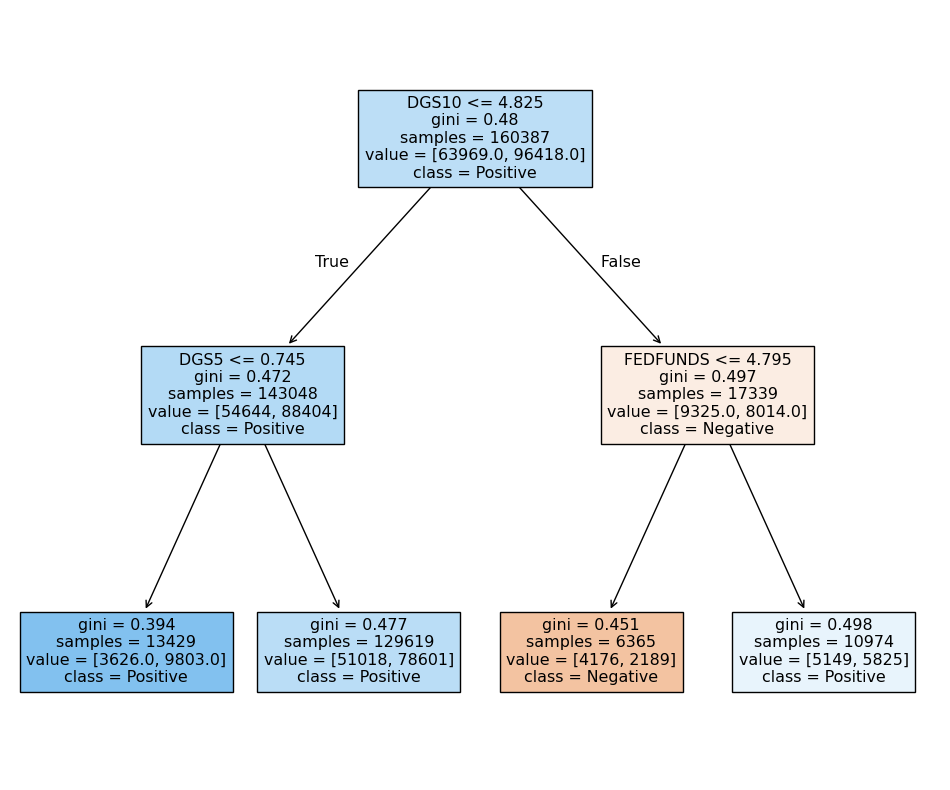

In [152]:
# Visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf_2 is your trained DecisionTreeClassifier
plt.figure(figsize=(12,10))  # Set the size of the figure
plot_tree(clf_2,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [153]:
  tree_rules = export_text(clf_2, feature_names=list(X_train), max_depth=1)
  print(tree_rules)

|--- DGS10 <= 4.83
|   |--- DGS5 <= 0.75
|   |   |--- class: 1
|   |--- DGS5 >  0.75
|   |   |--- class: 1
|--- DGS10 >  4.83
|   |--- FEDFUNDS <= 4.80
|   |   |--- class: 0
|   |--- FEDFUNDS >  4.80
|   |   |--- class: 1



## 1.3) [Code Snippet 3] Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [154]:
from sklearn.ensemble import RandomForestClassifier
import time

# (12 min runtime FOR v28 machine) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again

In [155]:
# %%time
# # hyper params tuning

# precision_matrix = {}
# best_precision = 0
# best_depth = 0
# best_estimators = 1

# for depth in [5, 7, 9, 11, 13, 15, 17, 19]:
#   for estimators in [10,50,100,200]:
#     print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

#     # Start timing
#     start_time = time.time()
#     # fitting the tree on X_train, y_train
#     rf = RandomForestClassifier(n_estimators = estimators,
#                                 max_depth = depth,
#                                 random_state = 42,
#                                 n_jobs = -1)

#     rf = rf.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = rf.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = rf.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

#     # saving to the dict
#     precision_matrix[depth, estimators] = round(precision_test,4)

#     # Measure elapsed time
#     elapsed_time = time.time() - start_time
#     print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_depth = depth
#       best_estimators = estimators
#       print(f'New best precision found for depth={depth}, estimators = {estimators}')

#     print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [156]:
# uncomment when you run the hyperparam tuning again
# print(precision_matrix)

In [157]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest
best_precision_matrix_random_forest = best_precision_matrix_random_forest = {
    (5, 10): 0.5498,
    (5, 50): 0.5511,
    (5, 100): 0.5511,
    (5, 200): 0.5511,
    (7, 10): 0.5540,
    (7, 50): 0.5492,
    (7, 100): 0.5495,
    (7, 200): 0.5515,
    (9, 10): 0.5411,
    (9, 50): 0.5461,
    (9, 100): 0.5507,
    (9, 200): 0.5517,
    (11, 10): 0.5623,
    (11, 50): 0.5559,
    (11, 100): 0.5565,
    (11, 200): 0.5521,
    (13, 10): 0.5510,
    (13, 50): 0.5591,
    (13, 100): 0.5614,
    (13, 200): 0.5575,
    (15, 10): 0.5596,
    (15, 50): 0.5592,
    (15, 100): 0.5585,
    (15, 200): 0.5505,
    (17, 10): 0.5538,
    (17, 50): 0.5543,
    (17, 100): 0.5510,
    (17, 200): 0.5493,
    (19, 10): 0.5611,
    (19, 50): 0.5559,
    (19, 100): 0.5599,
    (19, 200): 0.5544,
}

In [158]:
# # Define the precision_matrix from the long calculation above
# best_precision_matrix = {
#      (5, 10): 0.5498, (5, 20): 0.5506,
#      (5, 50): 0.5511, (5, 100): 0.5511,
#      (6, 10): 0.5555, (6, 20): 0.551,
#      (6, 50): 0.5498, (6, 100): 0.5509,
#      (7, 10): 0.554, (7, 20): 0.5478,
#      (7, 50): 0.5492, (7, 100): 0.5495,
#      (8, 10): 0.5475, (8, 20): 0.5425,
#      (8, 50): 0.5516, (8, 100): 0.5507}


In [159]:

# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[5, 20])

# Show the figure
fig.show()

In [160]:
# MANUALLY SELECTED BEST - should have enough complexity and smoothness (n_estimators)
rf_best_n_estimators = 50
# MANUALLY SELECTED BEST - should have enough complexity
rf_best_max_depth = 19

In [161]:
%%time

#
# several minutes to compute (2 min)

rf_best = RandomForestClassifier(n_estimators = rf_best_n_estimators,
                                 max_depth = rf_best_max_depth,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 2min 12s, sys: 567 ms, total: 2min 12s
Wall time: 1min 19s


## 1.4) [Code Snippet 1] Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many cases when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

In [162]:
from sklearn.linear_model import LogisticRegression

In [163]:
# Large feature magnitudes can cause convergence issues. If you haven’t already, scale your data:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_valid = scaler.fit_transform(X_train_valid)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [164]:
# UNCOMMENT TO RUN IT AGAIN

# precision_matrix = {}
# best_precision = 0
# best_C = 0
# best_iter = 0

# for c in [1, 0.1, 0.01]:
#   for iter in [50, 100, 200]:
#     print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
#     # fitting the tree on X_train, y_train
#     # hyperParam C should be between 0 and 1
#     lr = LogisticRegression(C=c,
#                             random_state=42,
#                             max_iter=iter,
#                             solver='sag',  # 'sag' - another option
#                             n_jobs=-1)

#     lr = lr.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = lr.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = lr.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#     # saving to the dict
#     precision_matrix[(c,iter)] = round(precision_test,4)
#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_C = c
#       best_iter = iter
#       print(f'New best precision found for C={c}')
#       print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

In [165]:
# UNCOMMENT TO SEE THE RESULTS OF THE RUN
# print(precision_matrix)

In [166]:
# Params on C, iter
best_precision_matrix_logistic_regression = {(1, 50): 0.5459, (1, 100): 0.5367, (1, 200): 0.5277, (0.1, 50): 0.5466, (0.1, 100): 0.5373, (0.1, 200): 0.5285, (0.01, 50): 0.5476, (0.01, 100): 0.5428, (0.01, 200): 0.54}


In [167]:
list(best_precision_matrix_logistic_regression.items())[0]

((1, 50), 0.5459)

In [168]:
# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

## 1.5) [Code Snippet 4 - ADVANCED] Neural Network (NN) and HyperParams tuning
* [Tutorial from Tensorflow.org](https://www.tensorflow.org/tutorials/keras/classification)
* [TowardsDataScience Hyperparameter Optimization with Keras](https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53)
* [Machine Learning Mastery tutorial with Keras Deep Learning](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)

In [169]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [170]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 208}

In [171]:
# you need to install TF if using a v28 machine
# !pip install tensorflow

In [172]:
import tensorflow as tf
import keras
from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense, Input, Dropout, Activation

In [173]:
# building one Neural Network when Parameters are known:
import datetime

# len(rez_train.keys())
def build_model(nn_params):
  # lr, first_neuron, second_neuron, first_dropout, second_dropout, activation_first, activation_second, optimizer
  model = keras.Sequential([
  layers.Dense(nn_params['first_layer_neurons'],
               activation=nn_params['activation_first_layer'],
               input_shape=[nn_params['input_shape']]),
  layers.Dropout(nn_params['first_layer_dropout']),
  layers.Dense(nn_params['second_layer_neurons'],
               activation=nn_params['activation_second_layer']),
  layers.Dropout(nn_params['second_layer_dropout']),
  layers.Dense(1, activation='sigmoid') # sigmoid is important for a Neural Network
  ])

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(lr)
  elif optimizer == 'nadam':
    opt = keras.optimizers.Nadam(lr)
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(lr)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(lr)
  else:
    opt = keras.optimizers.Adagrad(lr)
  model.compile(loss='binary_crossentropy', # mae/rmse for the Regression,
                optimizer=opt,
                metrics=['accuracy',keras.metrics.Precision()]) # or use [keras.metrics.Precision()] for a binary model : https://keras.io/api/metrics/classification_metrics/#precision-class
  return model

In [174]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 208}

In [175]:

model = build_model(nn_params)
model.summary()
# model.get_config()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        53,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,553 (467.00 KB)

 Trainable params: 119,553 (467.00 KB)

 Non-trainable params: 0 (0.00 B)

In [176]:
# trainable params in the model with max params (largest hidden layers size)
model.count_params()

119553

In [177]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print()
    print('.', end='')

In [178]:
# read tutorial about Binary Classification with Neural Network
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit


# HYPER_PARAMS_SPACE = PARAMS space
# WHEN MAX_MODELS>0: return after MAX_MODELS checked
# MAX_EPOCHS: how many epochs (periods when model weights are updated) do we need?
def train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE, MAX_MODELS=0, MAX_EPOCHS=250, EARLY_STOPPING_PATIENCE=20):

  # The patience parameter is the amount of epochs to check for improvement
  early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # we want accuracy to improve every single iteration (or at least in several iterations (EARLY STOPPING PARAM))
                                             patience = EARLY_STOPPING_PATIENCE)
  nn_params = {} # current hyperParams settings
  cur = 0 # models trained

  # best stats
  best_accuracy = 0
  best_model = None
  best_history = None

  for lr in HYPER_PARAMS_SPACE['lr']:
    for first_dropout in HYPER_PARAMS_SPACE['first_dropout']:
      for second_dropout in HYPER_PARAMS_SPACE['second_dropout']:
        for activation_first in HYPER_PARAMS_SPACE['activation_first']:
          for activation_second in HYPER_PARAMS_SPACE['activation_second']:
            for optimizer in HYPER_PARAMS_SPACE['optimizer']:
              for first_neuron in HYPER_PARAMS_SPACE['first_neuron']:
                for second_neuron in HYPER_PARAMS_SPACE['second_neuron']:
                  cur = cur+1

                  nn_params['learning_rate'] = lr
                  nn_params['first_layer_neurons'] = first_neuron
                  nn_params['first_layer_dropout'] = first_dropout
                  nn_params['second_layer_neurons'] = second_neuron
                  nn_params['second_layer_dropout'] = second_dropout
                  nn_params['activation_first_layer'] = activation_first
                  nn_params['activation_second_layer'] = activation_second
                  nn_params['optimizer'] = optimizer

                  # features count as an input shape
                  nn_params['input_shape'] = len(X_train.keys())

                  print(f'Using HyperParams:{nn_params}')

                  model = build_model(nn_params)
                  # model.summary()

                  frame = pd.DataFrame(data=[cur,lr,first_neuron,second_neuron,first_dropout,second_dropout, activation_first, activation_second, optimizer])

                  print(f"Training model {cur} with trainable params {model.count_params()} :")
                  t_start = datetime.datetime.now()
                  history = model.fit(
                                        X_train_valid,
                                        y_train_valid,
                                        epochs=MAX_EPOCHS,
                                        validation_data = (X_test, y_test),
                                        verbose=1, #change to 0 if you don't want to see the progress
                                        callbacks=[early_stop,PrintDot()])

                  t_diff = datetime.datetime.now() - t_start
                  frame = pd.DataFrame(data=[t_diff.seconds,
                                          len(history.epoch),
                                          history.history['val_accuracy'][0], # start of learning
                                          history.history['val_accuracy'][len(history.epoch)-1], # end of learning
                                          #  history.history['val_precision_2'][0], # start of learning
                                          #  history.history['val_precision_2'][len(history.epoch)-1], # end of learning
                                          ])

                  if history.history['val_accuracy'][len(history.epoch)-1]> best_accuracy:
                    best_accuracy = history.history['val_accuracy'][len(history.epoch)-1]
                    best_model = model
                    best_history = history

                  # early stopping of hyper params loop
                  if MAX_MODELS>0 and cur>=MAX_MODELS:
                    return best_model, best_history.history

                  print('==============================================================')

  return best_model, best_history.history #full hyper params search on all models

In [179]:
# UNCOMMENT TO RUN IT
# # returns best_model (trained) and best_history (history of train operations)
# best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
#                                                                  MAX_MODELS=2, #not more than 2 models
#                                                                  MAX_EPOCHS=250,
#                                                                  EARLY_STOPPING_PATIENCE=10
#                                                                  )

In [180]:
# UNCOMMENT WHEN RUN AGAIN

# best_history_nn = best_history
# best_model_nn = best_model

In [181]:
# best_model_nn.summary()

In [182]:
# check the best history of training
# best_history

In [183]:
# pre computed history
best_history_nn ={'accuracy': [0.6206425428390503,
  0.6563935875892639,
  0.6715070605278015,
  0.6781659126281738,
  0.6846689581871033,
  0.6899000406265259,
  0.6924314498901367,
  0.6940774321556091,
  0.6963594555854797,
  0.6981488466262817,
  0.6982797980308533,
  0.7005742192268372],
 'loss': [0.6485477089881897,
  0.6164013743400574,
  0.6015466451644897,
  0.5939826965332031,
  0.5864177346229553,
  0.5822728872299194,
  0.5788451433181763,
  0.5766140818595886,
  0.5728825926780701,
  0.5714946389198303,
  0.5709761381149292,
  0.5681091547012329],
 'precision_1': [0.6281318068504333,
  0.6705082058906555,
  0.6927300691604614,
  0.7030346393585205,
  0.7096523642539978,
  0.7157368659973145,
  0.7195449471473694,
  0.7237764596939087,
  0.724949061870575,
  0.7277039289474487,
  0.7285037040710449,
  0.7305046916007996],
 'val_accuracy': [0.5095517039299011,
  0.5176388025283813,
  0.5059220790863037,
  0.49360036849975586,
  0.4926133453845978,
  0.4922631084918976,
  0.49605196714401245,
  0.48605450987815857,
  0.48605450987815857,
  0.4821383059024811,
  0.47784003615379333,
  0.4782857894897461],
 'val_loss': [0.7736297845840454,
  0.9822676181793213,
  1.0234887599945068,
  1.1025390625,
  1.1842303276062012,
  1.1674247980117798,
  1.1660196781158447,
  1.2397290468215942,
  1.2409558296203613,
  1.2863727807998657,
  1.3408353328704834,
  1.328245759010315],
 'val_precision_1': [0.5571497082710266,
  0.5591427087783813,
  0.5572323799133301,
  0.5471343398094177,
  0.5460649728775024,
  0.546144962310791,
  0.5497111082077026,
  0.5439006090164185,
  0.5426294207572937,
  0.5389731526374817,
  0.5362157225608826,
  0.5376880168914795]}

In [184]:
X_train_valid.shape

(160387, 208)

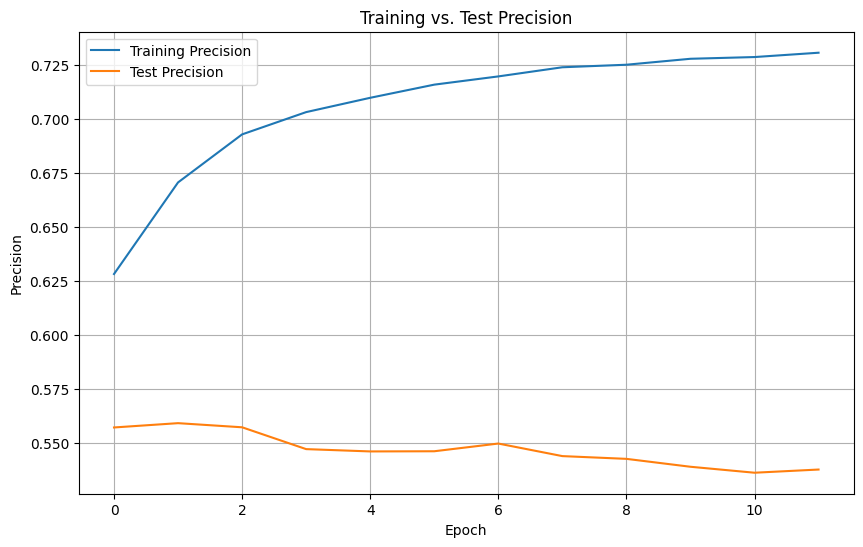

In [185]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_1'], label='Training Precision')
plt.plot(best_history_nn['val_precision_1'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

# 2) [Code Snippet 5] Different Decision rules to improve the Precision (varying Threshold)
* best model1 **(clf_best)**: Decision Tree (max_depth=15)
* best model2 **(rf_best)**: Random Forest (n_estimators=200, max_depth=17)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [186]:
# predicting probability instead of a label
y_pred_test = clf_best.predict_proba(X_test)

# y_pred_test = rf_best.predict_proba(X_test)

y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [187]:
# example prediction
y_pred_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [188]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])

# sample of predictions
y_pred_test_class1_df.sample(10)

Class1_probability
19491                 1.0
16178                 1.0
29077                 0.0
10444                 0.0
15164                 0.0
8500                  0.0
27827                 1.0
3301                  0.0
23416                 1.0
1484                  0.0

In [189]:
# Mean prediction is 0.3, median is 0.0, 75% quantile is 0.9
y_pred_test_class1_df.describe().T

count      mean       std  min  25%  50%  75%  max
Class1_probability  31408.0  0.409413  0.475608  0.0  0.0  0.0  1.0  1.0

In [190]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

np.float64(0.5510697911360163)

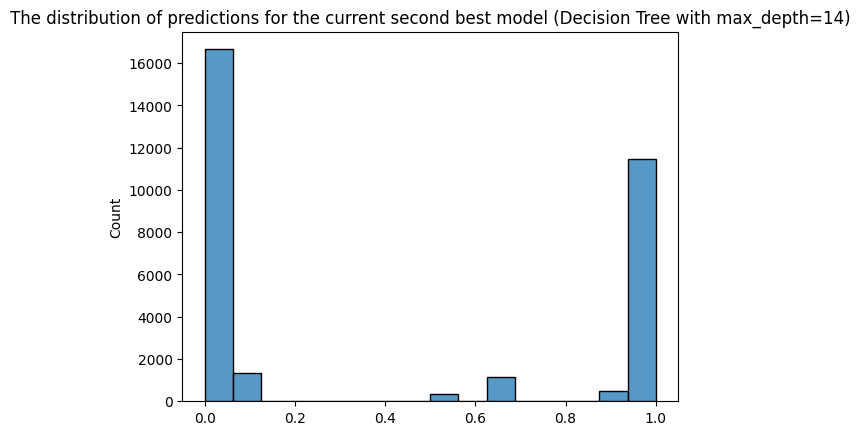

In [191]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title(f'The distribution of predictions for the current second best model (Decision Tree with max_depth={clf_best.get_depth()})')

# Show the plot
plt.show()

In [192]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [193]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [194]:
# full df_scores
df_scores

threshold     tp     fp     fn    tn  precision    recall  accuracy  \
0        0.00  17308  14100      0     0   0.551070  1.000000  0.551070   
1        0.02   7767   6982   9541  7118   0.526612  0.448752  0.473924   
2        0.04   7767   6982   9541  7118   0.526612  0.448752  0.473924   
3        0.06   7767   6982   9541  7118   0.526612  0.448752  0.473924   
4        0.08   7174   6287  10134  7813   0.532947  0.414490  0.477171   
5        0.10   7117   6283  10191  7817   0.531119  0.411197  0.475484   
6        0.12   7117   6283  10191  7817   0.531119  0.411197  0.475484   
7        0.14   7117   6283  10191  7817   0.531119  0.411197  0.475484   
8        0.16   7117   6283  10191  7817   0.531119  0.411197  0.475484   
9        0.18   7117   6283  10191  7817   0.531119  0.411197  0.475484   
10       0.20   7117   6283  10191  7817   0.531119  0.411197  0.475484   
11       0.22   7117   6283  10191  7817   0.531119  0.411197  0.475484   
12       0.24   7117   6283  10191  7817   0.531119  0.411197  0.475484   
13       0.26   7117   6283  10191  7817   0.531119  0.411197  0.475484   
14       0.28   7117   6283  10191  7817   0.531119  0.411197  0.475484   
15       0.30   7117   6283  10191  7817   0.531119  0.411197  0.475484   
16       0.32   7117   6283  10191  7817   0.531119  0.411197  0.475484   
17       0.34   7117   6283  10191  7817   0.531119  0.411197  0.475484   
18       0.36   7117   6283  10191  7817   0.531119  0.411197  0.475484   
19       0.38   7117   6283  10191  7817   0.531119  0.411197  0.475484   
20       0.40   7117   6283  10191  7817   0.531119  0.411197  0.475484   
21       0.42   7117   6283  10191  7817   0.531119  0.411197  0.475484   
22       0.44   7117   6283  10191  7817   0.531119  0.411197  0.475484   
23       0.46   7117   6283  10191  7817   0.531119  0.411197  0.475484   
24       0.48   7117   6283  10191  7817   0.531119  0.411197  0.475484   
25       0.50   7117   6283  10191  7817   0.531119  0.411197  0.475484   
26       0.52   6890   6162  10418  7938   0.527888  0.398082  0.472109   
27       0.54   6890   6162  10418  7938   0.527888  0.398082  0.472109   
28       0.56   6890   6162  10418  7938   0.527888  0.398082  0.472109   
29       0.58   6890   6162  10418  7938   0.527888  0.398082  0.472109   
30       0.60   6890   6162  10418  7938   0.527888  0.398082  0.472109   
31       0.62   6890   6162  10418  7938   0.527888  0.398082  0.472109   
32       0.64   6890   6162  10418  7938   0.527888  0.398082  0.472109   
33       0.66   6349   5570  10959  8530   0.532679  0.366825  0.473733   
34       0.68   6349   5570  10959  8530   0.532679  0.366825  0.473733   
35       0.70   6349   5570  10959  8530   0.532679  0.366825  0.473733   
36       0.72   6349   5570  10959  8530   0.532679  0.366825  0.473733   
37       0.74   6349   5570  10959  8530   0.532679  0.366825  0.473733   
38       0.76   6349   5570  10959  8530   0.532679  0.366825  0.473733   
39       0.78   6349   5570  10959  8530   0.532679  0.366825  0.473733   
40       0.80   6349   5570  10959  8530   0.532679  0.366825  0.473733   
41       0.82   6349   5570  10959  8530   0.532679  0.366825  0.473733   
42       0.84   6349   5570  10959  8530   0.532679  0.366825  0.473733   
43       0.86   6349   5570  10959  8530   0.532679  0.366825  0.473733   
44       0.88   6113   5340  11195  8760   0.533747  0.353189  0.473542   
45       0.90   6113   5340  11195  8760   0.533747  0.353189  0.473542   
46       0.92   6113   5340  11195  8760   0.533747  0.353189  0.473542   
47       0.94   6113   5340  11195  8760   0.533747  0.353189  0.473542   
48       0.96   6113   5340  11195  8760   0.533747  0.353189  0.473542   
49       0.98   6078   5317  11230  8783   0.533392  0.351167  0.473160   
50       1.00   6076   5315  11232  8785   0.533404  0.351052  0.473160   

    f1_score       tpr       fpr  
0   0.710567  1.000000  1.000000  
1   0.484574  0.448752  0.495177 

In [195]:
df_scores[(df_scores.threshold>=0.6) & (df_scores.threshold<=0.92)]

threshold    tp    fp     fn    tn  precision    recall  accuracy  \
30       0.60  6890  6162  10418  7938   0.527888  0.398082  0.472109   
31       0.62  6890  6162  10418  7938   0.527888  0.398082  0.472109   
32       0.64  6890  6162  10418  7938   0.527888  0.398082  0.472109   
33       0.66  6349  5570  10959  8530   0.532679  0.366825  0.473733   
34       0.68  6349  5570  10959  8530   0.532679  0.366825  0.473733   
35       0.70  6349  5570  10959  8530   0.532679  0.366825  0.473733   
36       0.72  6349  5570  10959  8530   0.532679  0.366825  0.473733   
37       0.74  6349  5570  10959  8530   0.532679  0.366825  0.473733   
38       0.76  6349  5570  10959  8530   0.532679  0.366825  0.473733   
39       0.78  6349  5570  10959  8530   0.532679  0.366825  0.473733   
40       0.80  6349  5570  10959  8530   0.532679  0.366825  0.473733   
41       0.82  6349  5570  10959  8530   0.532679  0.366825  0.473733   
42       0.84  6349  5570  10959  8530   0.532679  0.366825  0.473733   
43       0.86  6349  5570  10959  8530   0.532679  0.366825  0.473733   
44       0.88  6113  5340  11195  8760   0.533747  0.353189  0.473542   
45       0.90  6113  5340  11195  8760   0.533747  0.353189  0.473542   
46       0.92  6113  5340  11195  8760   0.533747  0.353189  0.473542   

    f1_score       tpr       fpr  
30  0.453887  0.398082  0.437021  
31  0.453887  0.398082  0.437021  
32  0.453887  0.398082  0.437021  
33  0.434461  0.366825  0.395035  
34  0.434461  0.366825  0.395035  
35  0.434461  0.366825  0.395035  
36  0.434461  0.366825  0.395035  
37  0.434461  0.366825  0.395035  
38  0.434461  0.366825  0.395035  
39  0.434461  0.366825  0.395035  
40  0.434461  0.366825  0.395035  
41  0.434461  0.366825  0.395035  
42  0.434461  0.366825  0.395035  
43  0.434461  0.366825  0.395035  
44  0.425090  0.353189  0.378723  
45  0.425090  0.353189  0.378723  
46  0.425090  0.353189  0.378723

In [196]:
# TODO: HA to build a similar dataframe for random_forest and find optimal thresholds

<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

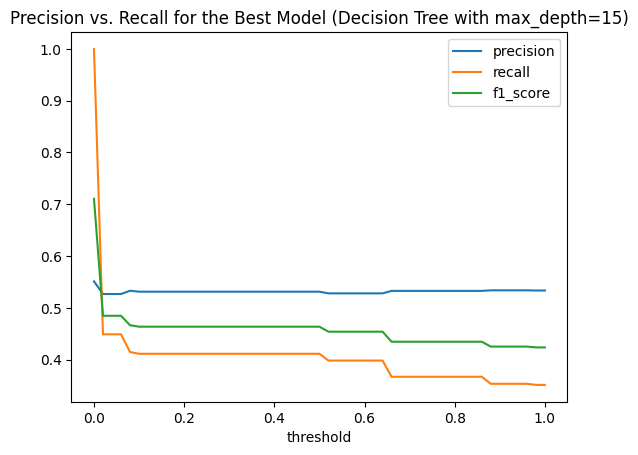

In [197]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [198]:
# existing predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best']

In [199]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_second_best_rule_84'] = (y_pred_all_class1_array >= 0.84).astype(int)

new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_clf_second_best_rule_92'] = (y_pred_all_class1_array >= 0.92).astype(int)


In [200]:
# adding Random Forest predictors (rf_best)
rf_best

RandomForestClassifier(max_depth=19, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [201]:
# make predictions of probabilities using the Random Forest model (rf_best)

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list


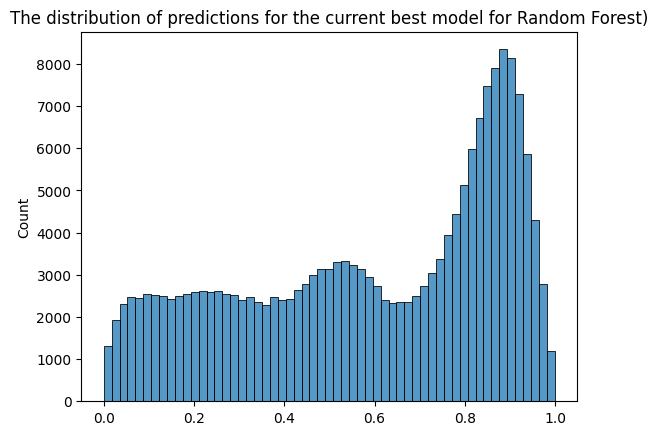

In [202]:
# PREDICTIONS ON A FULL DATASET - more smooth dataset - good sign
sns.histplot(y_pred_all_class1)

# Add a title
plt.title('The distribution of predictions for the current best model for Random Forest)')

# Show the plot
plt.show()

In [203]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.60 and 0.70
# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred11'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_65'] = (y_pred_all_class1_array >= 0.65).astype(int)

<Axes: >

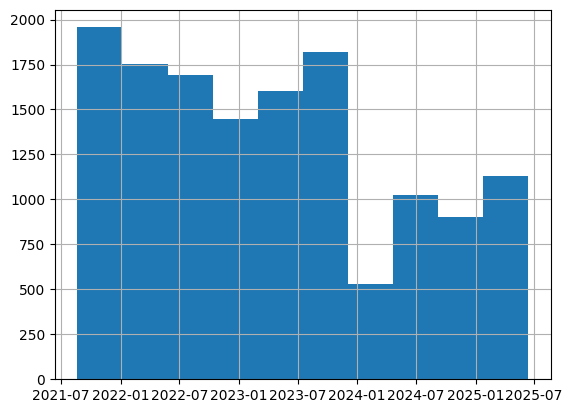

In [204]:
# Many positive predictions
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].Date.hist()

<Axes: >

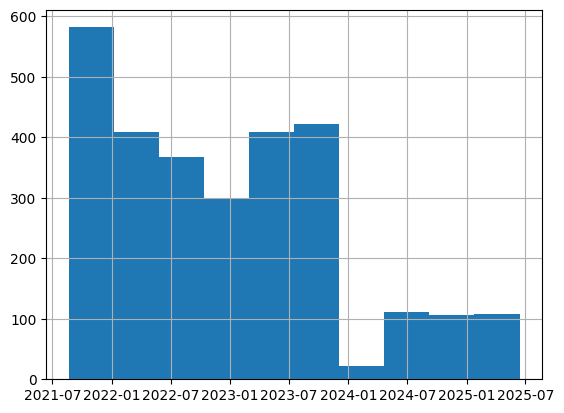

In [205]:
# When did it predict to trade for the "rare" positive prediction pred10?
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].Date.hist()

In [206]:
# sample of rare predictions with high threshold
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].sort_values(by='Date').sample(10)

Open         High          Low      Close_x       Volume  \
5603    613.140850   613.419962   593.602219   604.767151     414414.0   
6595   1970.165222  1989.293040  1943.434144  1981.785278    2808685.0   
7268    449.975716   452.295671   443.837481   445.239136   12884401.0   
6740    135.786543   137.610710   135.045476   137.135666     957683.0   
10398   157.439141   157.625869   153.291867   155.788101  105342000.0   
10700   171.413773   171.661295   169.582106   169.859329   50747300.0   
4392    129.231825   132.582407   127.934043   132.501892   30518000.0   
6683    103.943926   106.256096   103.934487   106.152290    1238900.0   
6455    385.997138   387.207733   381.806578   382.505005   15897679.0   
8166    693.883608   704.882452   685.275817   689.101501       9230.0   

       Dividends  Stock Splits         Ticker  Year      Month  ...  \
5603         0.0           0.0          MC.PA  2021    October  ...   
6595         0.0           0.0  HINDUNILVR.NS  2022      March  ...   
7268         0.0           0.0         ITC.NS  2024   December  ...   
6740         0.0           0.0         SIE.DE  2023   February  ...   
10398        0.0           0.0           AAPL  2022      March  ...   
10700        0.0           0.0           AAPL  2023        May  ...   
4392         0.0           0.0           GOOG  2022    January  ...   
6683         0.0           0.0            SAP  2022      April  ...   
6455         0.0           0.0        SBIN.NS  2021     August  ...   
8166         0.0           0.0         CDI.PA  2023  September  ...   

      is_correct_pred6 is_correct_pred7  proba_pred8  \
5603                 0                1     1.000000   
6595                 0                0     0.230769   
7268                 0                1     0.000000   
6740                 0                0     0.973684   
10398                0                0     0.000000   
10700                1                1     0.957780   
4392                 1                0     1.000000   
6683                 1                1     0.212766   
6455                 0                0     0.225352   
8166                 0                0     0.825503   

       pred8_clf_second_best_rule_84  proba_pred9  \
5603                               1     1.000000   
6595                               0     0.230769   
7268                               0     0.000000   
6740                               1     0.973684   
10398                              0     0.000000   
10700                              1     0.957780   
4392                               1     1.000000   
6683                               0     0.212766   
6455                               0     0.225352   
8166                               0     0.825503   

       pred9_clf_second_best_rule_92  proba_pred10  pred10_rf_best_rule_55  \
5603                               1      0.700923                       1   
6595                               0      0.677367                       1   
7268                               0      0.674719                       1   
6740                               1      0.653283                       1   
10398                              0      0.729053                       1   
10700                              1      0.668841                       1   
4392                               1      0.651063                       1   
6683                               0      0.732962                       1   
6455                               0      0.699425                       1   
8166                               0      0.669361                       1   

       proba_pred11  pred11_rf_best_rule_65  
5603       0.700923                       1  
6595       0.677367                       1  
7268       0.674719                       1  
6740       0.653283                       1  
10398      0.729053                       1  
10700      0.668841                       1  
4392       0.651063                

In [207]:
# List of ALL current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [208]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].groupby('Date')['pred11_rf_best_rule_65'].count())

In [209]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].groupby('Date')['pred10_rf_best_rule_55'].count())

In [210]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

991

In [211]:
pred10_daily_positive_count

pred11_rf_best_rule_65
Date                              
2021-08-20                       5
2021-08-23                       8
2021-08-24                       6
2021-08-25                       8
2021-08-26                       9
...                            ...
2025-06-06                       1
2025-06-09                       1
2025-06-10                       1
2025-06-12                       2
2025-06-13                       1

[686 rows x 1 columns]

array([[<Axes: title={'center': 'pred11_rf_best_rule_65'}>]], dtype=object)

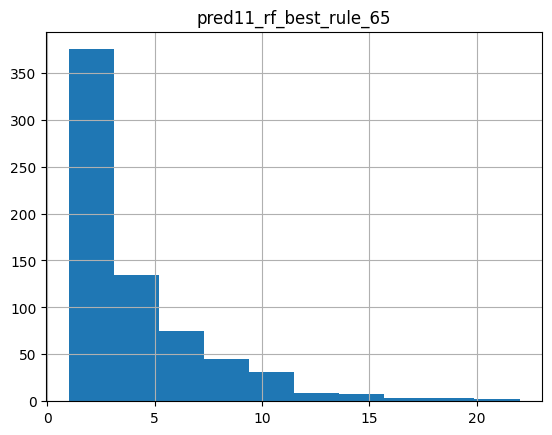

In [212]:
pred10_daily_positive_count.hist()

In [213]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

count      mean       std  min  25%  50%  75%   max
pred11_rf_best_rule_65  686.0  4.135569  3.401672  1.0  2.0  3.0  6.0  22.0

array([[<Axes: title={'center': 'pred10_rf_best_rule_55'}>]], dtype=object)

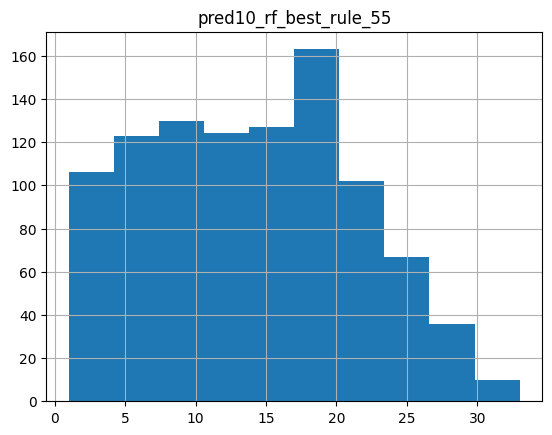

In [214]:
pred9_daily_positive_count.hist()

In [215]:
pred9_daily_positive_count.describe().T

count       mean       std  min  25%   50%   75%   max
pred10_rf_best_rule_55  988.0  14.019231  7.305647  1.0  8.0  14.0  20.0  33.0

## 2.3) Agg. stats on ALL predictions

In [216]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred7_clf_second_best', 'pred8_clf_second_best_rule_84', 'pred9_clf_second_best_rule_92', 'pred10_rf_best_rule_55', 'pred11_rf_best_rule_65']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10', 'is_correct_pred11']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: i

In [217]:
# check approx. periods : Train is 2000-01...2017-01, Valid is 2017-01..2020-09, Test is 2020-09..2024-05
new_df.groupby('split').Date.agg(['min','max'])

min        max
split                           
test       2021-08-20 2025-06-13
train      2000-01-03 2017-10-25
validation 2017-10-26 2021-08-19

In [218]:
# GET PREDICTION NUMBER: Easier solution not using regular expressions

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [219]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [220]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [221]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred7',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred11']

In [222]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum    19304.000000   99983.000000  23780.000000
                              mean       0.614620       0.770701      0.775679
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum    18453.000000  104367.000000  22899.000000
                              mean       0.587525       0.804494      0.746942
pred7_clf_second_best         count  31408.000000  129730.000000  30657.000000
                              sum    18610.000000   90493.000000  22587.000000
                              mean       0.592524       0.697549      0.736765
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum    15292.000000   33359.000000  11688.000000
                              mean       0.486882       0.257142      0.381251
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum    11508.000000   20742.000000   6905.000000
                              mean       0.366403       0.159886      0.225234
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum    13851.000000   77623.000000  19889.000000
                              mean       0.441002       0.598343      0.648759
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum     2837.000000   73542.000000  19239.000000
                              mean       0.090327       0.566885      0.627557

In [223]:
# 10 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred0_manual_cci              count  31408.000000  129730.000000  30657.000000
                              sum      794.000000    3428.000000    886.000000
                              mean       0.025280       0.026424      0.028900
pred1_manual_prev_g1          count  31408.000000  129730.000000  30657.000000
                              sum    17991.000000   76372.000000  19721.000000
                              mean       0.572816       0.588700      0.643279
pred2_manual_prev_g1_and_snp  count  31408.000000  129730.000000  30657.000000
                              sum    13367.000000   57404.000000  16695.000000
                              mean       0.425592       0.442488      0.544574
pred3_manual_dgs10_5          count  31408.000000  129730.000000  30657.000000
                              sum      997.000000   13333.000000  11908.000000
                              mean       0.031744       0.102775      0.388427
pred4_manual_dgs10_fedfunds   count  31408.000000  129730.000000  30657.000000
                              sum     5660.000000   30611.000000      0.000000
                              mean       0.180209       0.235959      0.000000
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum    19304.000000   99983.000000  23780.000000
                              mean       0.614620       0.770701      0.775679
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum    18453.000000  104367.000000  22899.000000
                              mean       0.587525       0.804494      0.746942
pred7_clf_second_best         count  31408.000000  129730.000000  30657.000000
                              sum    18610.000000   90493.000000  22587.000000
                              mean       0.592524       0.697549      0.736765
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum    15292.000000   33359.000000  11688.000000
                              mean       0.486882       0.257142      0.381251
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum    11508.000000   20742.000000   6905.000000
                              mean       0.366403       0.159886      0.225234
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum    13851.000000   77623.000000  19889.000000
                              mean       0.441002       0.598343      0.648759
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum     2837.000000   73542.000000  19239.000000
                              mean       0.090327       0.566885      0.627557

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_pred10"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

### [Code Snippet 7] 3.1.1 Calculate fin. result from simulations for one predictor 'pred6_clf_best'

In [224]:
# current prediction
pred = 'pred6_clf_5'

In [225]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close_x.count()

np.int64(31408)

In [226]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

991

In [227]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [228]:
# SAMPLE: compare the predictions from pred6_clf_best to real is_positive_growth_30d_future
new_df[['growth_future_30d','is_positive_growth_30d_future',pred]].sample(10)

growth_future_30d  is_positive_growth_30d_future  pred6_clf_5
8622            1.090028                              1            1
2580            1.042670                              1            1
5797            1.089992                              1            1
1532            1.013841                              1            1
10209           1.078414                              1            1
4345            0.924959                              0            1
6340            0.907624                              0            1
1122            0.941940                              0            1
5882            1.068279                              1            1
1252            0.988720                              0            0

In [229]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)

In [230]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [231]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [232]:
# sample results
COLUMNS_FIN_RESULT = ['Date','Ticker','Close_x']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT].sample(10)

Date       Ticker      Close_x  growth_future_30d  \
6934  2023-08-02  RELIANCE.NS  1238.969971           0.986707   
10861 2023-04-14          JPM   132.084625           0.987097   
5443  2023-03-10          HDB    63.751137           1.094691   
13262 2025-01-07          LLY   770.380432           1.131769   
7125  2024-08-27       SIE.DE   163.299271           1.078147   
6066  2023-04-19         INFY    13.987108           1.082599   
7090  2024-03-21  RELIANCE.NS  1446.067017           0.960820   
3037  2024-06-14         META   502.826202           0.918736   
6828  2022-10-31          SAP    93.318245           1.143140   
6973  2024-01-23       SIE.DE   153.952225           1.133197   

       is_positive_growth_30d_future  pred6_clf_5  sim1_gross_rev_pred6  \
6934                               0            1             -1.329259   
10861                              0            1             -1.290263   
5443                               1            1              9.469101   
13262                              1            1             13.176917   
7125                               1            1              7.814740   
6066                               1            1              8.259934   
7090                               0            1             -3.918048   
3037                               0            1             -8.126393   
6828                               1            1             14.313968   
6973                               1            1             13.319685   

       sim1_fees_pred6  sim1_net_rev_pred6  
6934              -0.2           -1.529259  
10861             -0.2           -1.490263  
5443              -0.2            9.269101  
13262             -0.2           12.976917  
7125              -0.2            7.614740  
6066              -0.2            8.059934  
7090              -0.2           -4.118048  
3037              -0.2           -8.326393  
6828              -0.2           14.113968  
6973              -0.2           13.119685

In [233]:
# DAILY INVESTMENTS
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

33.0


In [234]:
# how many times do we invest daily (a lot)
df_investments_count_daily.describe().T

count      mean       std  min   25%   50%   75%   max
pred6_clf_5  585.0  31.54359  4.708841  8.0  33.0  33.0  33.0  33.0

In [235]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()

sim1_gross_rev_pred6    66660.624344
sim1_fees_pred6         -3690.600000
sim1_net_rev_pred6      62996.424344
dtype: float64

### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [236]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 30 * sim1_q75_investments_per_day # 30 (trading) days  in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 794 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    1613.043262
sim1_fees_pred0         -158.800000
sim1_net_rev_pred0      1459.643262
dtype: float64
        Count Investments in 4 years (on TEST): 794
        Gross Revenue: $1613
        Fees (0.2% for buy+sell): $158
        Net Revenue: $1459
        Fees are 9 % from Gross Revenue
        Capital Required : $6000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $7459 (Vfinal)
        Average CAGR on TEST (4 years) : 1.056, or 5.6% 
        Average daily stats: 
            Average net revenue per investment: $1.84 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 17991 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    29618

In [237]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [238]:
# final comparison
df_sim1_results

prediction  sim1_count_investments  sim1_gross_rev  \
0                pred0_manual_cci                     794     1613.043262   
1            pred1_manual_prev_g1                   17991    29618.243475   
2    pred2_manual_prev_g1_and_snp                   13367    17019.666162   
3            pred3_manual_dgs10_5                     997     2845.843984   
4     pred4_manual_dgs10_fedfunds                    5660     8594.814190   
5                    pred5_clf_10                   19304    51553.789401   
6                     pred6_clf_5                   18453    66660.624344   
7           pred7_clf_second_best                   18610    50810.912580   
8   pred8_clf_second_best_rule_84                   15292    46250.461108   
9   pred9_clf_second_best_rule_92                   11508    36130.377214   
10         pred10_rf_best_rule_55                   13851    32200.909605   
11         pred11_rf_best_rule_65                    2837     8080.887771   

    sim1_fees  sim1_net_rev  sim1_fees_percentage  sim1_average_net_revenue  \
0      -158.8   1459.643262              0.098447                  1.838342   
1     -3598.2  26167.843475              0.121486                  1.454496   
2     -2673.4  14475.066162              0.157077                  1.082896   
3      -199.4   2646.443984              0.070067                  2.654407   
4     -1132.0   7660.814190              0.131707                  1.353501   
5     -3860.8  47783.189401              0.074889                  2.475300   
6     -3690.6  62996.424344              0.055364                  3.413885   
7     -3722.0  47165.712580              0.073252                  2.534428   
8     -3058.4  43264.061108              0.066127                  2.829196   
9     -2301.6  33888.777214              0.063703                  2.944802   
10    -2770.2  29493.709605              0.086029                  2.129356   
11     -567.4   7517.887771              0.070215                  2.649943   

    sim1_avg_investments_per_day  sim1_capital  sim1_CAGR  \
0                       1.850816        6000.0   1.055946   
1                      18.154390       75000.0   1.077694   
2                      22.967354       81000.0   1.041960   
3                      31.156250       96000.0   1.006822   
4                      31.620112       99000.0   1.018808   
5                      19.657841       87000.0   1.115653   
6                      31.543590       99000.0   1.131013   
7                      18.779011       78000.0   1.125506   
8                      15.493414       66000.0   1.134314   
9                      11.707019       42000.0   1.159397   
10                     14.019231       60000.0   1.105122   
11                      4.135569       18000.0   1.091172   

    sim1_growth_capital_4y  
0                 1.243274  
1                 1.348905  
2                 1.178705  
3                 1.027567  
4                 1.077382  
5                 1.549232  
6                 1.636328  
7                 1.604689  
8                 1.655516  
9                 1.806876  
10                1.491562  
11                1.417660

In [239]:

# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'},
    height=600  # <- Increase height here

)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

In [240]:
# detailed info from the bubble chart above on the winners
# top 1 result
df_sim1_results[df_sim1_results.prediction.isin(['pred9_clf_second_best_rule_92'])]

prediction  sim1_count_investments  sim1_gross_rev  \
9  pred9_clf_second_best_rule_92                   11508    36130.377214   

   sim1_fees  sim1_net_rev  sim1_fees_percentage  sim1_average_net_revenue  \
9    -2301.6  33888.777214              0.063703                  2.944802   

   sim1_avg_investments_per_day  sim1_capital  sim1_CAGR  \
9                     11.707019       42000.0   1.159397   

   sim1_growth_capital_4y  
9                1.806876

In [241]:
# top 2-3 results
df_sim1_results[df_sim1_results.prediction.isin(['pred8_clf_second_best_rule_84','pred7_clf_second_best'])]

prediction  sim1_count_investments  sim1_gross_rev  \
7          pred7_clf_second_best                   18610    50810.912580   
8  pred8_clf_second_best_rule_84                   15292    46250.461108   

   sim1_fees  sim1_net_rev  sim1_fees_percentage  sim1_average_net_revenue  \
7    -3722.0  47165.712580              0.073252                  2.534428   
8    -3058.4  43264.061108              0.066127                  2.829196   

   sim1_avg_investments_per_day  sim1_capital  sim1_CAGR  \
7                     18.779011       78000.0   1.125506   
8                     15.493414       66000.0   1.134314   

   sim1_growth_capital_4y  
7                1.604689  
8                1.655516